In [146]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import sys
import random
import quaternion

from matplotlib import colors

PROJ_DIR = os.path.dirname(os.path.abspath('.'))
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

import open3d as o3d
from scipy.spatial.transform import Rotation

from tqdm.notebook import tqdm

## Prepare Split

In [2]:
data_dir = '/scratch/kinal.mehta/HabitatGibson/data'

In [3]:
frame_ids = [0, 1]

valid_fps = []
for scene in os.listdir(data_dir):
    filenames = sorted(os.listdir(os.path.join(data_dir, scene, '0', 'pose')), 
                       key=lambda x: int(os.path.splitext(x)[0]))
    valid_fps.extend(['{} {}'.format(scene, os.path.splitext(x)[0]) for x in filenames[:-1]])
    
len(valid_fps)

25507

In [4]:
/scratch/kinal.mehta/pose_preds/gibson_gtpose_resnet_sparse_SR_stcwith open('../splits/gibson/gibson_eval_all_traj.txt', 'w') as f:
    f.writelines([x + '\n' for x in valid_fps])

## Evaluation

In [2]:
def get_pose(pose_path, side='l'):
    baseline = 0.2
    cam_height = 1
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.

    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    agent_pose = np.load(pose_path, allow_pickle=True).item()

    R = np.eye(4)
    R[:3, :3] = quaternion.as_rotation_matrix(agent_pose['rotation'])

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']

    M = (T @ R @ cam_to_agent).astype(np.float32)

    return M

In [3]:
model_output = dict()
model_output["sparse_SR_stc"] = '/scratch/kinal.mehta/pose_preds/gibson_gtpose_resnet_sparse_SR_stc/dump/0/{}/0/left_pose/{}.npy'
model_output["sparse_SR_5fid_stc"] = '/scratch/kinal.mehta/pose_preds/gibson_gtpose_resnet_sparse_SR_5fid_stc/dump/0/{}/0/left_pose/{}.npy'

In [4]:
root_dir = '/scratch/kinal.mehta/HabitatGibson'

gt_rgb = '{}/data/{}/0/left_rgb/{}.jpg'
gt_depth = '{}/data/{}/0/left_depth/{}.png'
gt_semantics = '{}/semantics/{}/0/left_rgb/{}.png'
gt_bev = '{}/bevs/sim/{}/0/bev/{}.png'
proj_bev = '{}/bevs/gtdepth/{}/0/bev/{}.png'

gtpose_dir = '{}/data/{}/0/pose'

In [5]:
with open('/scratch/kinal.mehta/HabitatGibson/train_gibson_scenes.txt', 'r') as f:
    train_scenes = f.read().splitlines()
    
print(train_scenes)

['Allensville', 'Beechwood', 'Benevolence', 'Coffeen', 'Cosmos', 'Forkland', 'Hanson', 'Hiteman', 'Klickitat', 'Lakeville', 'Leonardo', 'Lindenwood', 'Marstons', 'Merom', 'Mifflinburg', 'Newfields', 'Onaga', 'Pinesdale', 'Pomaria', 'Ranchester', 'Shelbyville', 'Stockman', 'Tolstoy', 'Wainscott', 'Woodbine']


In [6]:
with open('/scratch/kinal.mehta/HabitatGibson/val_gibson_scenes.txt', 'r') as f:
    val_scenes = f.read().splitlines()
    
print(val_scenes)

['Collierville', 'Corozal', 'Darden', 'Markleeville', 'Wiconisco']


### Qualitative

In [28]:
scene = 'Wiconisco'
scene_dir = gtpose_dir.format(root_dir, scene)

model_traj = {}

filenames = os.listdir(scene_dir)
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0]))

for model_name in model_output:
    pred_traj = []
    gt_traj = []
    T_of = np.eye(4)  # frame to origin T
    
    for idx, filename in enumerate(filenames):
        gt_pose = get_pose(os.path.join(scene_dir, filename), side='l')
        gt_traj.append(gt_pose @ [0, 0, 0, 1])

        if idx == 0:
            T_ts = gt_pose.copy()
        else:
            T_st = np.load(model_output[model_name].format(scene, idx-1))
            T_ts = np.linalg.inv(T_st)

        T_of = T_of @ T_ts
        abs_position = (T_of @ [0, 0, 0, 1])[:3]
        pred_traj.append(abs_position)
    
    model_traj[model_name] = np.array(pred_traj)
    gt_traj = np.array(gt_traj)

print(gt_traj.shape)

(678, 4)


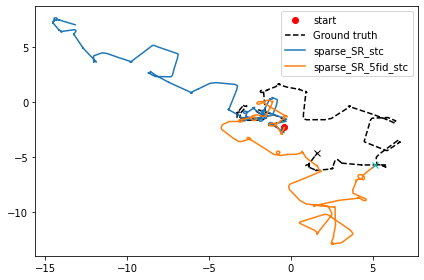

In [29]:
plt.plot(gt_traj[0, 0], gt_traj[0, 2], 'ro', label='start')
plt.plot(gt_traj[:, 0], gt_traj[:, 2], 'k--', label='Ground truth')

for model_name, pred_traj in model_traj.items():
    plt.plot(pred_traj[:, 0], pred_traj[:, 2], '-', label=model_name)

plt.legend()
plt.plot(gt_traj[-1, 0], gt_traj[-1, 2], 'kx', label='end')
plt.plot(pred_traj[-1, 0], pred_traj[-1, 2], 'cx', label='end')
plt.tight_layout()
plt.show()

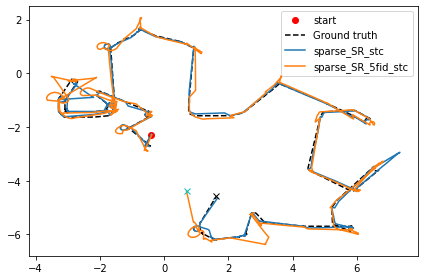

In [9]:
scene = 'Wiconisco'
scene_dir = gtpose_dir.format(root_dir, scene)

model_traj = {}

filenames = os.listdir(scene_dir)
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0]))

for model_name in model_output:
    pred_traj = []
    gt_traj = []
    T_of = np.eye(4)  # frame to origin T
    
    for idx, filename in enumerate(filenames):
        gt_pose = get_pose(os.path.join(scene_dir, filename), side='l')
        gt_traj.append(gt_pose @ [0, 0, 0, 1])

        if idx == 0:
            T_ts = gt_pose.copy()
        else:
            T_st = np.load(model_output[model_name].format(scene, idx-1))
            T_ts = np.linalg.inv(T_st)

        T_of = T_of @ T_ts
        abs_position = (T_of @ [0, 0, 0, 1])[:3]
        pred_traj.append(abs_position)
        
        if idx % 20 == 0:
            T_of = gt_pose.copy()
    
    model_traj[model_name] = np.array(pred_traj)
    gt_traj = np.array(gt_traj)

plt.plot(gt_traj[0, 0], gt_traj[0, 2], 'ro', label='start')
plt.plot(gt_traj[:, 0], gt_traj[:, 2], 'k--', label='Ground truth')

for model_name, pred_traj in model_traj.items():
    plt.plot(pred_traj[:, 0], pred_traj[:, 2], '-', label=model_name)

plt.legend()
plt.plot(gt_traj[-1, 0], gt_traj[-1, 2], 'kx', label='end')
plt.plot(pred_traj[-1, 0], pred_traj[-1, 2], 'cx', label='end')
plt.tight_layout()
plt.show()

### Quantitative

## ICP based refinent

While doing registration, we can use ICP to refine our pose predictions. The predicted pose can actually serve as good estimates for initial poses. This holds true while training.

During inference time, we intend to do depth, pose and bev prediction. Now the stitching of the BEV map is done offline and can again use refinement over predicted poses by estimating the homography matrix using correspondences and the predicted pose as initial estimate.

In [373]:
def get_depth(pose_path, side='l'):
    folder = 'left_depth' if side == 'l' else 'right_depth'
    depth_path = pose_path.replace('pose', folder).replace('npy', 'png')
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535
    return depth

def get_color(pose_path, side='l'):
    folder = 'left_rgb' if side == 'l' else 'right_rgb'
    rgb_path = pose_path.replace('pose', folder).replace('npy', 'jpg')
    rgb = cv2.imread(rgb_path, -1)
    return rgb

def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect(u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)

    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

def get_pose_diff(pose1, pose2):
    """Get pose difference between pose1 and pose2
    """
    r1 = pose1[:3, :3]
    r2 = pose2[:3, :3]
    r21 = r2.T @ r1

    r21 = Rotation.from_matrix(r21).as_euler('xyz', degrees=True)

    p1 = pose1[:3, 3]
    p2 = pose2[:3, 3]
    p21 = p2 - p1

    output = dict(pos=p21, rot=r21)
    return output

In [374]:
scene = 'Wiconisco'
scene_dir = gtpose_dir.format(root_dir, scene)

model_traj = {}

filenames = os.listdir(scene_dir)
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0]))

for model_name in model_output:
    pred_poses = []
    gt_poses = []
    T_of = np.eye(4)  # frame to origin T
    
    for idx, filename in enumerate(filenames):
        gt_pose = get_pose(os.path.join(scene_dir, filename), side='l')
        gt_poses.append(gt_pose.copy())

        if idx == 0:
            T_ts = gt_pose # To ensure same starting pose
        else:
            T_st = np.load(model_output[model_name].format(scene, idx-1))
            T_ts = np.linalg.inv(T_st)

        T_of = T_of @ T_ts
        pred_poses.append(T_of.copy())
    
    model_traj[model_name] = np.array(pred_poses)
    gt_poses = np.array(gt_poses)

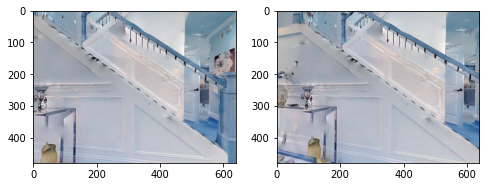

In [375]:
K = camera_intrinsic_transform(f_x=320, c_x=320, f_y=320, c_y=240)
baseline = 0.2
cam_height = 1

idx1 = 0
idx2 = 1

scene_dir = gtpose_dir.format(root_dir, scene)

pose1 = gt_poses[idx1]
pose2 = gt_poses[idx2]

T21 = np.linalg.inv(pose2) @ pose1

color1 = get_color(os.path.join(scene_dir, f'{idx1}.npy'), side='l')
color2 = get_color(os.path.join(scene_dir, f'{idx2}.npy'), side='l')

depth1 = get_depth(os.path.join(scene_dir, f'{idx1}.npy'), side='l')
depth2 = get_depth(os.path.join(scene_dir, f'{idx2}.npy'), side='l')

fig, ax = plt.subplots(ncols=2, figsize=(4*2, 3))
ax[0].imshow(color1)
ax[1].imshow(color2)

plt.show()

In [376]:
model_traj.keys()
model_name = 'sparse_SR_stc'
pred_poses = model_traj[model_name]

In [377]:
pcd1 = img_to_lid(depth1, K)
pcd2 = img_to_lid(depth2, K)

In [378]:
if 'pc1' in globals():
    del pc1, pc2

pc1 = o3d.geometry.PointCloud()
pc1.points = o3d.utility.Vector3dVector(pcd1)

pc2 = o3d.geometry.PointCloud()
pc2.points = o3d.utility.Vector3dVector(pcd2)

In [379]:
print(T21)

[[ 9.9163890e-01  0.0000000e+00  1.2904389e-01  8.3608925e-04]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.2904389e-01  0.0000000e+00  9.9163890e-01  1.2904406e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [380]:
threshold = 0.02
trans_init = np.eye(4)
# trans_init[:3,:] = np.random.random((3,4))

reg_p2p = o3d.registration.registration_icp(
        pc1, pc2, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPoint(),
        o3d.registration.ICPConvergenceCriteria(max_iteration = 100000))

reg_T_eye = reg_p2p.transformation.astype(np.float32)
print(reg_p2p)
print()
print(reg_T_eye)
print()
print(get_pose_diff(T21, reg_T_eye))


registration::RegistrationResult with fitness=7.521615e-01, inlier_rmse=4.148617e-03, and correspondence_set size of 231064
Access transformation to get result.

[[ 9.9152553e-01  1.0441053e-03  1.2990764e-01 -9.7265407e-02]
 [-8.4020017e-04  9.9999833e-01 -1.6244125e-03 -6.7052782e-02]
 [-1.2990911e-01  1.5014980e-03  9.9152476e-01  3.9389763e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

{'pos': array([-0.0981015 , -0.06705278,  0.02648536], dtype=float32), 'rot': array([-0.09307206, -0.04991902,  0.04822108])}


In [381]:
pred_T21 = np.linalg.inv(pred_poses[idx2]) @ pred_poses[idx1]
print(pred_T21.astype(np.float32))
print()
print(get_pose_diff(T21, pred_T21))

[[ 9.8716158e-01 -6.9335126e-04  1.5972301e-01  1.8554820e-05]
 [ 7.3150324e-04  9.9999970e-01 -1.8006674e-04  5.2401889e-04]
 [-1.5972285e-01  2.9459290e-04  9.8716182e-01  1.4576213e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

{'pos': array([-0.00081753,  0.00052402,  0.00167181]), 'rot': array([-0.01032203, -1.77647413, -0.04159207])}


In [382]:
threshold = 0.02
trans_init = pred_T21
# trans_init[:3,:] = np.random.random((3,4))

reg_p2p = o3d.registration.registration_icp(
        pc1, pc2, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPoint(),
        o3d.registration.ICPConvergenceCriteria(max_iteration = 1000))
T_reg_pred = reg_p2p.transformation.astype(np.float32)

print(reg_p2p)
print()
print(T_reg_pred)
print()
print(get_pose_diff(T21, T_reg_pred))

registration::RegistrationResult with fitness=8.735286e-01, inlier_rmse=3.289974e-03, and correspondence_set size of 268348
Access transformation to get result.

[[ 9.9165934e-01  2.3345387e-04  1.2888566e-01  2.4887223e-03]
 [-2.4704894e-04  1.0000000e+00  8.9495516e-05  8.2899653e-04]
 [-1.2888563e-01 -1.2059014e-04  9.9165946e-01  1.2182576e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

{'pos': array([ 0.00165263,  0.000829  , -0.00072183], dtype=float32), 'rot': array([0.00512772, 0.00914212, 0.01415568])}


#### Refine entire trajectory using ICP

In [383]:
K = camera_intrinsic_transform(f_x=320, c_x=320, f_y=320, c_y=240)
baseline = 0.2
cam_height = 1

In [397]:
def refine_pose_icp(idx1, idx2, init_T21):
    
    depth1 = get_depth(os.path.join(scene_dir, f'{idx1}.npy'), side='l')
    depth2 = get_depth(os.path.join(scene_dir, f'{idx2}.npy'), side='l')
    
    pcd1 = img_to_lid(depth1, K)
    pcd2 = img_to_lid(depth2, K)
    
    pc1 = o3d.geometry.PointCloud()
    pc1.points = o3d.utility.Vector3dVector(pcd1)

    pc2 = o3d.geometry.PointCloud()
    pc2.points = o3d.utility.Vector3dVector(pcd2)
    
    reg_p2p = o3d.registration.registration_icp(
        pc1, pc2, 0.02, init_T21,
        o3d.registration.TransformationEstimationPointToPoint(),
        o3d.registration.ICPConvergenceCriteria(max_iteration = 1000))
    
    refined_T21 = reg_p2p.transformation.astype(np.float32)
    
    del pc1, pc2
    
    return refined_T21

In [398]:
offset = 1  # How many frames back should we go to perform ICP and correct drift

tgt_indices = [(max(0, idx2 - offset), idx2) for idx2 in range(offset, len(pred_poses), offset)]

tgt_indices[:7]

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]

  0%|          | 0/7 [00:00<?, ?it/s]

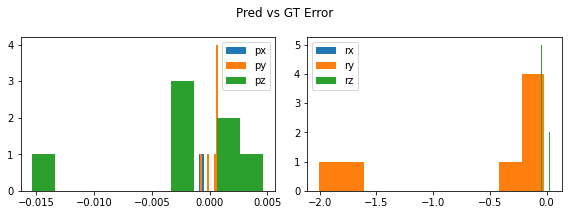

In [399]:
p_errs = []
r_errs = []

for idx1, idx2 in tqdm(tgt_indices[:7]):
    target_T21 = np.linalg.inv(gt_poses[idx2]) @ gt_poses[idx1]
    pred_T21 = np.linalg.inv(pred_poses[idx2]) @ pred_poses[idx1]
    
    err = get_pose_diff(target_T21, pred_T21)
    
    p_errs.append(err['pos'])
    r_errs.append(err['rot'])
    
p_errs = np.array(p_errs)
r_errs = np.array(r_errs)

fig, ax = plt.subplots(ncols=2, figsize=(2*4, 3))

ax[0].hist(p_errs[:, 0], label='px')
ax[0].hist(p_errs[:, 1], label='py')
ax[0].hist(p_errs[:, 2], label='pz')
ax[0].legend()

ax[1].hist(r_errs[:, 0], label='rx')
ax[1].hist(r_errs[:, 1], label='ry')
ax[1].hist(r_errs[:, 2], label='rz')
ax[1].legend()

plt.suptitle('Pred vs GT Error')
plt.tight_layout()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

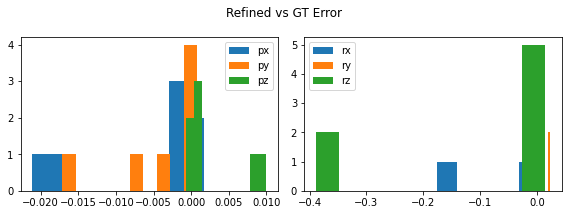

In [403]:
pos_errs = []
rot_errs = []

refined_poses = pred_poses.copy()

for idx1, idx2 in tqdm(tgt_indices[:7]):
    target_T21 = np.linalg.inv(gt_poses[idx2]) @ gt_poses[idx1]
    
    pose1 = pred_poses[idx1]
    pose2 = pred_poses[idx2]
    init_T21 = np.linalg.inv(pose2) @ pose1
    
    refined_T21 = refine_pose_icp(idx1, idx2, init_T21)
    
    err = get_pose_diff(target_T21, refined_T21)
    
    pos_errs.append(err['pos'])
    rot_errs.append(err['rot'])
    
pos_errs = np.array(pos_errs)
rot_errs = np.array(rot_errs)

fig, ax = plt.subplots(ncols=2, figsize=(2*4, 3))

ax[0].hist(pos_errs[:, 0], label='px')
ax[0].hist(pos_errs[:, 1], label='py')
ax[0].hist(pos_errs[:, 2], label='pz')
ax[0].legend()

ax[1].hist(rot_errs[:, 0], label='rx')
ax[1].hist(rot_errs[:, 1], label='ry')
ax[1].hist(rot_errs[:, 2], label='rz')
ax[1].legend()

plt.suptitle('Refined vs GT Error')
plt.tight_layout()
plt.show()

In [404]:
np.sum(rot_errs, axis=0)

array([0.01415568, 0.00774296, 0.02600021, 0.38897527, 0.34955688,
       0.01906663, 0.02261187])

In [405]:
np.sum(pos_errs, axis=0)

array([0.00165263, 0.00112017, 0.00322256, 0.0211194 , 0.01662112,
       0.00146624, 0.0011277 ], dtype=float32)

In [413]:
refined_poses = [pred_poses[0].copy()] * 21

for idx1, idx2 in tqdm(tgt_indices[:20]):
    pose1 = pred_poses[idx1]
    pose2 = pred_poses[idx2]
    init_T21 = np.linalg.inv(pose2) @ pose1
    
    refined_T21 = refine_pose_icp(idx1, idx2, init_T21)
    refined_pose2 = pose1 @ np.linalg.inv(refined_T21)
    
    refined_poses[idx2] = refined_pose2
    
refined_poses = np.array(refined_poses)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [409]:
for idx1, idx2 in tqdm(tgt_indices[:7]):
    T_of = refined_poses[idx1]
    for idx in range(idx1+1, idx2):
        T_st = np.load(model_output[model_name].format(scene, idx-1))
        T_ts = np.linalg.inv(T_st)

        T_of = T_of @ T_ts
        refined_poses[idx] = T_of.copy()

  0%|          | 0/7 [00:00<?, ?it/s]

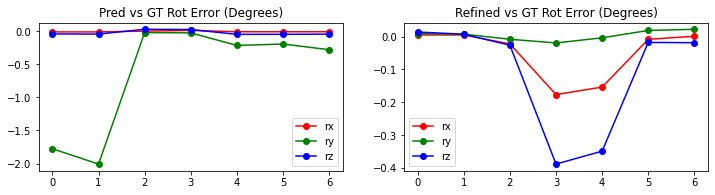

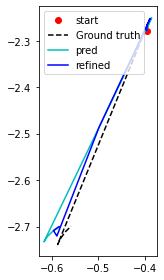

In [411]:
traj_start = 0
traj_end = 21

gt_traj = (gt_poses @ [0, 0, 0, 1])[traj_start:traj_len, :3]
pred_traj = (pred_poses @ [0, 0, 0, 1])[traj_start:traj_len, :3]
refined_traj = (refined_poses @ [0, 0, 0, 1])[traj_start:traj_len, :3]

fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(221)
ax.plot(r_errs[traj_start:traj_len-1, 0], 'ro-', label='rx')
ax.plot(r_errs[traj_start:traj_len-1, 1], 'go-', label='ry')
ax.plot(r_errs[traj_start:traj_len-1, 2], 'bo-', label='rz')
ax.legend()
ax.set_title('Pred vs GT Rot Error (Degrees)')
             
ax = plt.subplot(222)
ax.plot(rot_errs[traj_start:traj_len-1, 0], 'ro-', label='rx')
ax.plot(rot_errs[traj_start:traj_len-1, 1], 'go-', label='ry')
ax.plot(rot_errs[traj_start:traj_len-1, 2], 'bo-', label='rz')
ax.legend()
ax.set_title('Refined vs GT Rot Error (Degrees)')

fig = plt.figure()
ax = plt.gca()

ax.plot(gt_traj[0, 0], gt_traj[0, 2], 'ro', label='start')
ax.plot(gt_traj[:, 0], gt_traj[:, 2], 'k--', label='Ground truth')

ax.plot(pred_traj[:, 0], pred_traj[:, 2], 'c-', label='pred')
ax.plot(refined_traj[:, 0], refined_traj[:, 2], 'b-', label='refined')

ax.legend()

# for _, idx2 in tgt_indices[traj_start:traj_len-1]:
#     ax.plot(refined_traj[idx2, 0], refined_traj[idx2, 2], 'kx')
    
ax.set_aspect('equal')

plt.tight_layout()
plt.show()